In [2]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

#sklearn
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.preprocessing import KBinsDiscretizer

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, precision_score, recall_score, make_scorer
from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer

from sklearn.neighbors import KNeighborsClassifier

<h3>Functions</h3>

In [3]:
def plot_grid_search_results(grid_results, grid_best_params, grid_best_score):
    
    fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (12,18)) #figsize = (13,30)
    
    ax1.errorbar(x = grid_results['param_n_neighbors'].data, 
                 y = grid_results['mean_test_f1'],
                 color = '#B8002E',
                 yerr = grid_results['std_test_f1'],
                 ecolor = 'orange')
    ax1.set_xlabel('n_neigbors')
    ax1.set_ylabel('f1')
    ax1.set_title('Classification F1')
    
    ax2.errorbar(x = grid_results['param_n_neighbors'].data, 
                 y = grid_results['mean_test_recall'],
                 color = '#B8002E',
                 yerr = grid_results['std_test_recall'],
                 ecolor = 'orange')
    ax2.set_xlabel('n_neigbors') 
    ax2.set_ylabel('recall')
    ax2.set_title('Classification Recall')
    
    ax3.errorbar(x = grid_results['param_n_neighbors'].data, 
                 y = grid_results['mean_test_roc_auc'],
                 color = '#B8002E',
                 yerr = grid_results['std_test_roc_auc'],
                 ecolor = 'orange')
    ax3.plot([grid_best_params['n_neighbors']], [grid_best_score], 
              marker='.', 
              markeredgewidth=3,
              c='r')
    ax3.annotate('best k', xy = (grid_best_params['n_neighbors'], grid_best_score),
                 xytext = (grid_best_params['n_neighbors'] + 1, grid_best_score + 0.02),
                 arrowprops=dict(facecolor='black', shrink=0.01))
    ax3.set_xlabel('n_neigbors') 
    ax3.set_ylabel('roc auc')
    ax3.set_title('Classification Roc Auc')

    fig.tight_layout()
    plt.show()

In [4]:
def results_permutation_importance(res, attr):
    
    # get importance
    importance = res.importances_mean
    
    # summarize feature importance
    feature_importances = []
    for col, imp in zip(attr, importance):
        feature_importances.append((col, imp))
  
    sorted_feature_importances = sorted(feature_importances, key=lambda tup:(-tup[1], tup[0]))
    
    return sorted_feature_importances

In [5]:
def plot_permutation_importance(res, attr, tit):
    
    fig, ax = plt.subplots(figsize = (12,8)) 
    
    feature_names = np.r_[attr]
    
    importance = res.importances_mean
    sorted_idx = res.importances_mean.argsort()
    
    y_ticks = np.arange(0, len(feature_names))
    ax.barh(y_ticks, importance[sorted_idx], height=0.7, color = "#CC6600")
    ax.set_yticklabels(feature_names[sorted_idx])
    ax.set_yticks(y_ticks)
    ax.set_title(tit)
    
    fig.tight_layout()
    plt.show()

In [6]:
def draw_confusion_matrix(Clf, X, y):
    
    titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
    
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(Clf, X, y,
                                 cmap='OrRd',
                                 normalize=normalize)
        disp.ax_.set_title(title)
    
    plt.show()

In [7]:
def draw_roc_curve(Y_test, Y_pred):
    
    fig, ax = plt.subplots() #figsize = (13,30)
    
    fpr, tpr, _ = roc_curve(Y_test, Y_pred)
    roc_auc = roc_auc_score(Y_test, Y_pred, average = None)
    
    ax.plot(fpr, tpr, color = "#994D00", label='ROC curve (area = %0.2f)' % (roc_auc))
    ax.plot([0, 1], [0, 1], 'r--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate') 
    ax.set_title('Roc curve of the model')
    ax.tick_params(axis='both')
    ax.legend(loc="lower right", fontsize=14, frameon=False)
    
    fig.tight_layout()
    plt.show()

In [8]:
df = pd.read_csv("Numerical_NON_NORMALIZED_Train_HR_Employee_Attrition.csv")

In [9]:
df

,Age,Attrition,BusinessTravel_Non-Travel,BusinessTravel_Travel_Rarely,BusinessTravel_Travel_Frequently,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
0,52,0,0,1,0,9,4,2,0,3,...,17,3,0,2,2,8,7,156.61,0.39,2
1,36,0,0,1,0,1,1,2,0,3,...,14,3,1,3,3,1,8,157.94,0.41,2
2,25,0,0,0,1,16,3,3,0,3,...,25,3,1,4,3,1,5,448.06,0.70,3
3,33,0,0,1,0,5,4,2,0,3,...,14,2,0,1,3,3,7,271.91,0.84,2
4,31,0,0,1,0,9,2,3,1,3,...,12,3,0,2,3,10,2,106.37,0.21,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,38,1,0,1,0,12,3,3,1,4,...,15,4,0,2,3,10,0,282.47,0.79,3
879,37,0,0,1,0,16,2,4,1,4,...,13,2,2,3,2,17,0,76.29,0.71,3
880,33,1,1,0,0,6,4,2,1,1,...,18,2,0,2,2,11,7,272.88,0.75,2
881,33,0,0,1,0,4,1,3,0,2,...,12,1,0,2,4,3,2,208.67,0.86,2


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883 entries, 0 to 882
Data columns (total 36 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Age                                     883 non-null    int64  
 1   Attrition                               883 non-null    int64  
 2   BusinessTravel_Non-Travel               883 non-null    int64  
 3   BusinessTravel_Travel_Rarely            883 non-null    int64  
 4   BusinessTravel_Travel_Frequently        883 non-null    int64  
 5   DistanceFromHome                        883 non-null    int64  
 6   Education                               883 non-null    int64  
 7   EnvironmentSatisfaction                 883 non-null    int64  
 8   Gender                                  883 non-null    int64  
 9   JobInvolvement                          883 non-null    int64  
 10  JobLevel                                883 non-null    int64 

In [11]:
df.describe()

,Age,Attrition,BusinessTravel_Non-Travel,BusinessTravel_Travel_Rarely,BusinessTravel_Travel_Frequently,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
count,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,...,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000
mean,36.554926,0.173273,0.101925,0.733862,0.164213,9.201586,2.886750,2.684032,0.388448,2.750849,...,15.207248,2.716874,0.793884,2.665912,2.767837,6.326161,3.919592,234.245832,0.463918,2.322763
std,8.266129,0.378698,0.302721,0.442188,0.370679,8.241818,1.008285,1.092567,0.487674,0.729354,...,3.589332,1.078137,0.865362,1.187828,0.721713,4.523567,3.435392,130.196652,0.319880,0.535595
min,18.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,26.040000,0.000000,1.000000
25%,30.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000,0.000000,2.000000,...,12.000000,2.000000,0.000000,2.000000,2.000000,3.000000,2.000000,130.630000,0.130000,2.000000
50%,35.000000,0.000000,0.000000,1.000000,0.000000,7.000000,3.000000,3.000000,0.000000,3.000000,...,14.000000,3.000000,1.000000,2.000000,3.000000,5.000000,3.000000,212.280000,0.530000,2.000000
75%,42.000000,0.000000,0.000000,1.000000,0.000000,14.000000,4.000000,4.000000,1.000000,3.000000,...,18.000000,4.000000,1.000000,3.000000,3.000000,9.000000,7.000000,309.905000,0.760000,3.000000
max,60.000000,1.000000,1.000000,1.000000,1.000000,29.000000,5.000000,4.000000,1.000000,4.000000,...,25.000000,4.000000,3.000000,6.000000,4.000000,20.000000,16.000000,590.980000,0.950000,4.000000


<h3>Feature selection</h3>

In [12]:
features_sel = [col for col in df.columns if col != 'Attrition']

X_features_sel = df[features_sel].values
y_features_sel = df['Attrition']

OverTime                                           0.024692
JobSatisfaction                                    0.011308
JobRole_Sales_Representative                       0.010519
JobRole_Manufacturing_Director                     0.009376
StockOptionLevel                                   0.009102
JobRole_Laboratory_Technician                      0.008175
EnvironmentSatisfaction                            0.007330
RelationshipSatisfaction                           0.006227
JobRole_Research_Scientist                         0.006018
JobInvolvement                                     0.005326
TrainingTimesLastYear                              0.004640
WorkLifeBalance                                    0.004512
Age                                                0.003982
OverallSatisfaction                                0.003613
NumCompaniesWorked                                 0.003166
JobRole_Healthcare_Representative                  0.002696
YearsInCurrentRole                      

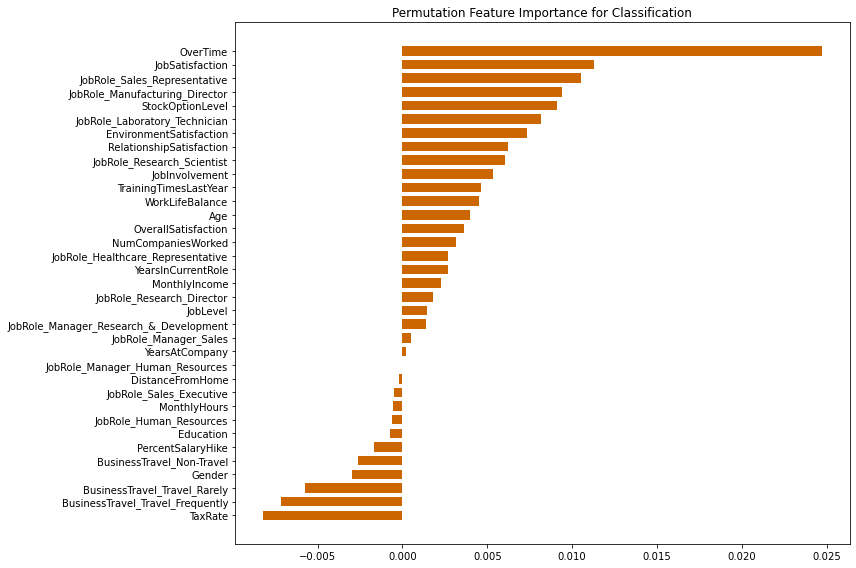

In [13]:
scaler_prova = MinMaxScaler()
X_features_sel_normalized = scaler_prova.fit_transform(X_features_sel)

model = KNeighborsClassifier()

model.fit(X_features_sel_normalized, y_features_sel)

results_features_sel = permutation_importance(model, X_features_sel_normalized, y_features_sel, scoring='roc_auc', n_repeats = 10)

sorted_feat_imp = results_permutation_importance(results_features_sel, features_sel)

#print results
for t in sorted_feat_imp:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
#plot results
t = 'Permutation Feature Importance for Classification'
plot_permutation_importance(results_features_sel, features_sel, t)

In [14]:
df = df.drop(['YearsInCurrentRole','JobRole_Manager_Sales',
              'JobRole_Manager_Human_Resources', 'JobRole_Sales_Executive',
              'JobRole_Human_Resources','YearsAtCompany', 'MonthlyIncome','MonthlyHours',
              'Education','Gender','BusinessTravel_Non-Travel',
              'PercentSalaryHike','BusinessTravel_Travel_Frequently',
              'BusinessTravel_Travel_Rarely','TaxRate', 'JobRole_Healthcare_Representative'], axis = 1)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883 entries, 0 to 882
Data columns (total 20 columns):
 #   Column                                  Non-Null Count  Dtype
---  ------                                  --------------  -----
 0   Age                                     883 non-null    int64
 1   Attrition                               883 non-null    int64
 2   DistanceFromHome                        883 non-null    int64
 3   EnvironmentSatisfaction                 883 non-null    int64
 4   JobInvolvement                          883 non-null    int64
 5   JobLevel                                883 non-null    int64
 6   JobRole_Laboratory_Technician           883 non-null    int64
 7   JobRole_Manager_Research_&_Development  883 non-null    int64
 8   JobRole_Manufacturing_Director          883 non-null    int64
 9   JobRole_Research_Director               883 non-null    int64
 10  JobRole_Research_Scientist              883 non-null    int64
 11  JobRole_Sales_Repre

<h3>Discretization with KBinsDiscretizer and Column Transformer</h3>

Continuous features to discretize:
- <b>Age</b>
- <b>DistanceFromHome</b>
- <b>YearsAtCompany</b>
- <b>YearsInCurrentRole</b>
- <b>NumCompaniesWorked</b>
- <b>MonthlyIncome</b>
- <b>MonthlyHours</b>
- <b>PercentSalaryHike</b>

In [31]:
columns_to_discretize = ['Age','DistanceFromHome','YearsAtCompany','YearsInCurrentRole',
'NumCompaniesWorked','MonthlyIncome','MonthlyHours','PercentSalaryHike']

In [32]:
remaining_columns = []

for column in columns_to_discretize:
    if column in df:
        remaining_columns.append(column)
        
remaining_columns

['Age', 'DistanceFromHome', 'NumCompaniesWorked']

In [33]:
columns_to_discretize = remaining_columns
columns_to_discretize

['Age', 'DistanceFromHome', 'NumCompaniesWorked']

In [34]:
ct = ColumnTransformer([('k_means_discretizer', 
                         KBinsDiscretizer(n_bins = 4, encode = 'ordinal', strategy = 'kmeans'),
                        ['Age','DistanceFromHome','NumCompaniesWorked'])], 
                       remainder = "drop")

In [35]:
df.head()

,Age,Attrition,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobRole_Laboratory_Technician,JobRole_Manager_Research_&_Development,JobRole_Manufacturing_Director,JobRole_Research_Director,JobRole_Research_Scientist,JobRole_Sales_Representative,JobSatisfaction,NumCompaniesWorked,OverTime,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,OverallSatisfaction
0,52,0,9,2,3,3,0,0,0,1,0,0,3,9,0,3,0,2,2,2
1,36,0,1,2,3,5,0,1,0,0,0,0,3,1,1,3,1,3,3,2
2,25,0,16,3,3,2,0,0,0,0,0,0,4,1,1,3,1,4,3,3
3,33,0,5,2,3,1,0,0,0,0,1,0,2,2,0,2,0,1,3,2
4,31,0,9,3,3,1,1,0,0,0,0,0,4,1,0,3,0,2,3,3


In [36]:
df_temp = pd.DataFrame(ct.fit_transform(df), columns = columns_to_discretize)
df_temp.head()

,Age,DistanceFromHome,NumCompaniesWorked
0,3.0,1.0,3.0
1,1.0,0.0,0.0
2,0.0,2.0,0.0
3,1.0,0.0,0.0
4,1.0,1.0,0.0


In [37]:
df.head()

,Age,Attrition,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobRole_Laboratory_Technician,JobRole_Manager_Research_&_Development,JobRole_Manufacturing_Director,JobRole_Research_Director,JobRole_Research_Scientist,JobRole_Sales_Representative,JobSatisfaction,NumCompaniesWorked,OverTime,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,OverallSatisfaction
0,52,0,9,2,3,3,0,0,0,1,0,0,3,9,0,3,0,2,2,2
1,36,0,1,2,3,5,0,1,0,0,0,0,3,1,1,3,1,3,3,2
2,25,0,16,3,3,2,0,0,0,0,0,0,4,1,1,3,1,4,3,3
3,33,0,5,2,3,1,0,0,0,0,1,0,2,2,0,2,0,1,3,2
4,31,0,9,3,3,1,1,0,0,0,0,0,4,1,0,3,0,2,3,3


In [38]:
for column in df_temp:
    if column in df:
        df[column] = df_temp[column]

In [39]:
df.head()

,Age,Attrition,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobRole_Laboratory_Technician,JobRole_Manager_Research_&_Development,JobRole_Manufacturing_Director,JobRole_Research_Director,JobRole_Research_Scientist,JobRole_Sales_Representative,JobSatisfaction,NumCompaniesWorked,OverTime,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,OverallSatisfaction
0,3.0,0,1.0,2,3,3,0,0,0,1,0,0,3,3.0,0,3,0,2,2,2
1,1.0,0,0.0,2,3,5,0,1,0,0,0,0,3,0.0,1,3,1,3,3,2
2,0.0,0,2.0,3,3,2,0,0,0,0,0,0,4,0.0,1,3,1,4,3,3
3,1.0,0,0.0,2,3,1,0,0,0,0,1,0,2,0.0,0,2,0,1,3,2
4,1.0,0,1.0,3,3,1,1,0,0,0,0,0,4,0.0,0,3,0,2,3,3


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883 entries, 0 to 882
Data columns (total 20 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Age                                     883 non-null    float64
 1   Attrition                               883 non-null    int64  
 2   DistanceFromHome                        883 non-null    float64
 3   EnvironmentSatisfaction                 883 non-null    int64  
 4   JobInvolvement                          883 non-null    int64  
 5   JobLevel                                883 non-null    int64  
 6   JobRole_Laboratory_Technician           883 non-null    int64  
 7   JobRole_Manager_Research_&_Development  883 non-null    int64  
 8   JobRole_Manufacturing_Director          883 non-null    int64  
 9   JobRole_Research_Director               883 non-null    int64  
 10  JobRole_Research_Scientist              883 non-null    int64 

<h3>Divide into features and target</h3>

In [41]:
attributes = [col for col in df.columns if col != 'Attrition']

X = df[attributes].values
y = df['Attrition']

<h3>Stratified Holdout combined with Stratified K-fold Cross Validation</h3>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.6438680784711898
Best parameters: {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=4, p=1, weights='distance')

Best k ('n_neighbors'): 4

Plots of the metrics used by the grid search


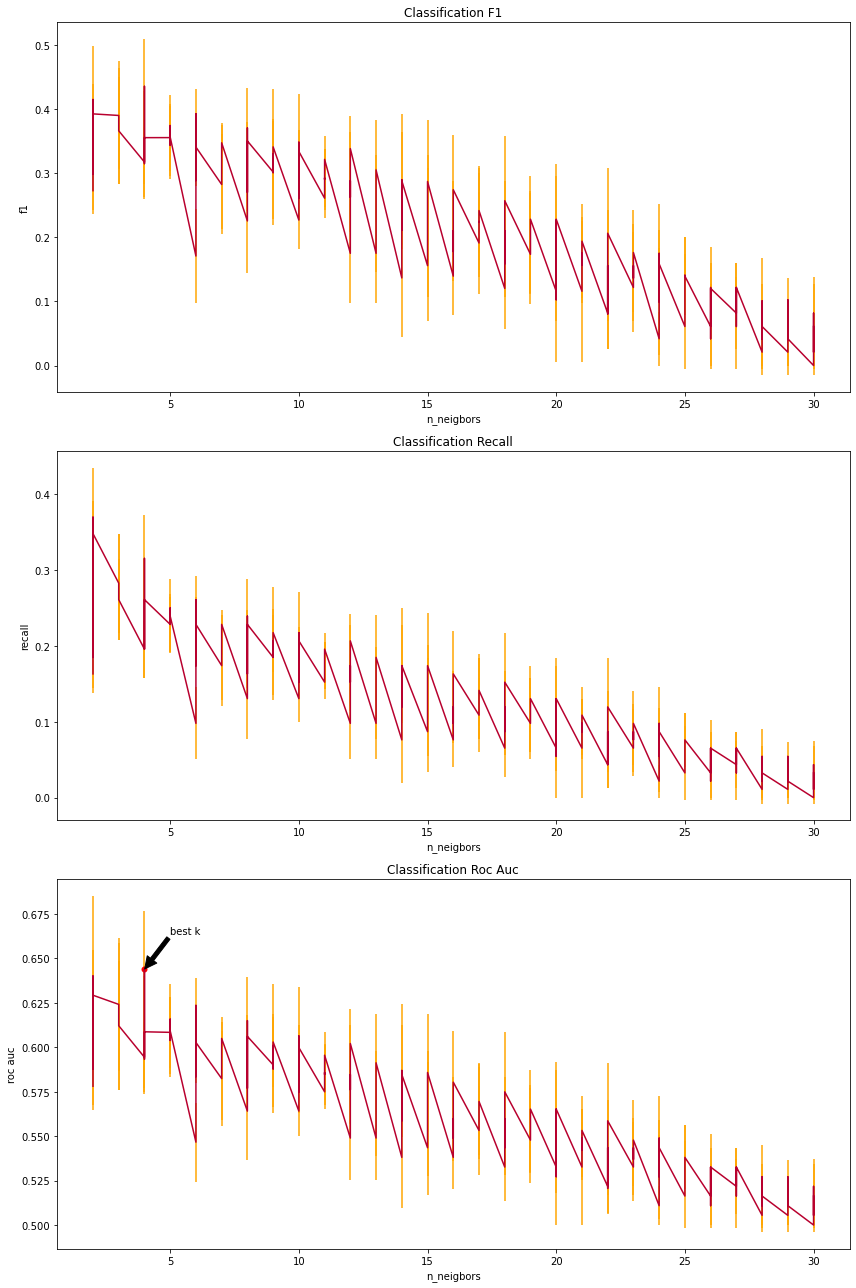



Permutation importances of the training set

OverTime                                           0.006420
JobRole_Laboratory_Technician                      0.003027
RelationshipSatisfaction                           0.000963
JobRole_Sales_Representative                       0.000863
DistanceFromHome                                   0.000510
JobSatisfaction                                    0.000495
EnvironmentSatisfaction                            0.000468
StockOptionLevel                                   0.000403
NumCompaniesWorked                                 0.000368
JobRole_Research_Scientist                         0.000353
Age                                                0.000177
JobInvolvement                                     0.000147
JobRole_Manufacturing_Director                     0.000134
WorkLifeBalance                                    0.000087
TrainingTimesLastYear                              0.000015
JobRole_Research_Director                          0.

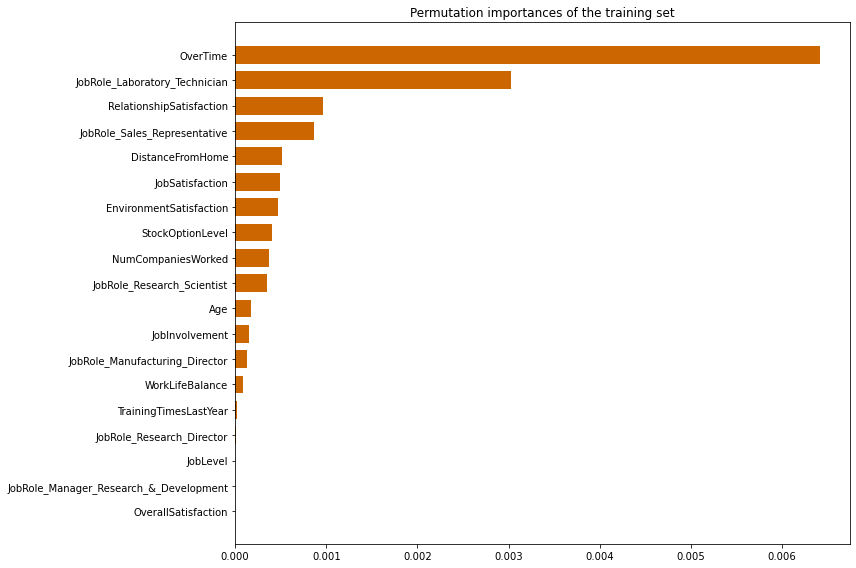



Predictions

Permutation importances of the test set

OverTime                                           0.069101
Age                                                0.037282
EnvironmentSatisfaction                            0.037145
JobSatisfaction                                    0.029838
JobRole_Research_Scientist                         0.024212
JobRole_Sales_Representative                       0.021177
RelationshipSatisfaction                           0.018858
JobLevel                                           0.018813
JobRole_Laboratory_Technician                      0.016785
StockOptionLevel                                   0.014628
OverallSatisfaction                                0.006258
JobRole_Manager_Research_&_Development             0.002123
JobRole_Research_Director                          0.001597
TrainingTimesLastYear                              0.001181
WorkLifeBalance                                    0.000719
JobRole_Manufacturing_Director              

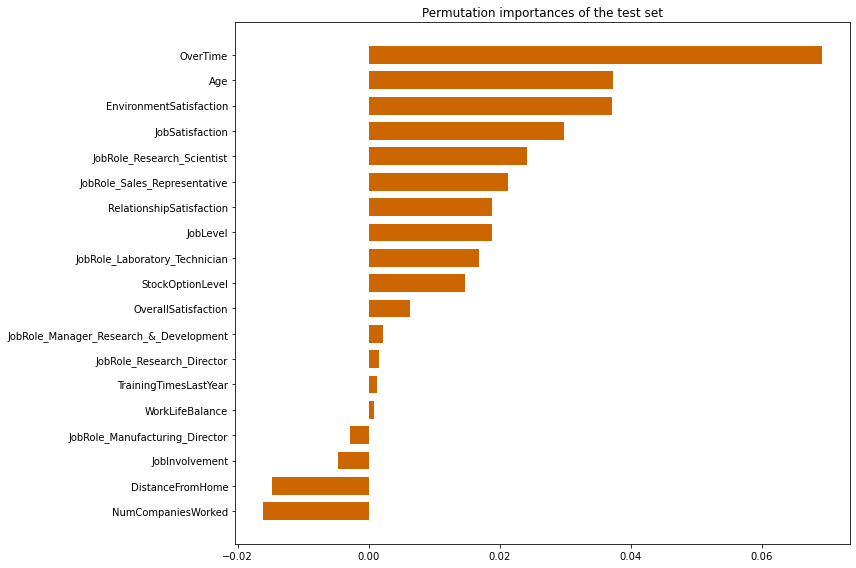



Confusion matrix


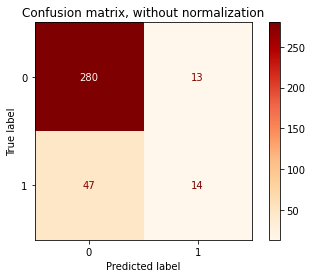

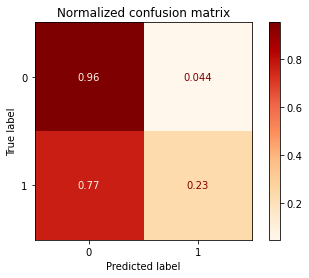


Classification report
              precision    recall  f1-score   support

           0       0.86      0.96      0.90       293
           1       0.52      0.23      0.32        61

    accuracy                           0.83       354
   macro avg       0.69      0.59      0.61       354
weighted avg       0.80      0.83      0.80       354


Metrics

Accuracy 0.8305084745762712
F1-score [0.90322581 0.31818182]
Precision [0.85626911 0.51851852]
Recall [0.9556314 0.2295082]
Roc_auc 0.5925697980193588


Roc curve



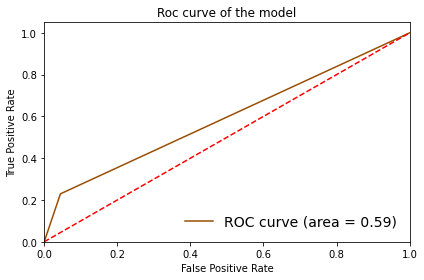


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.6257091617804585
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


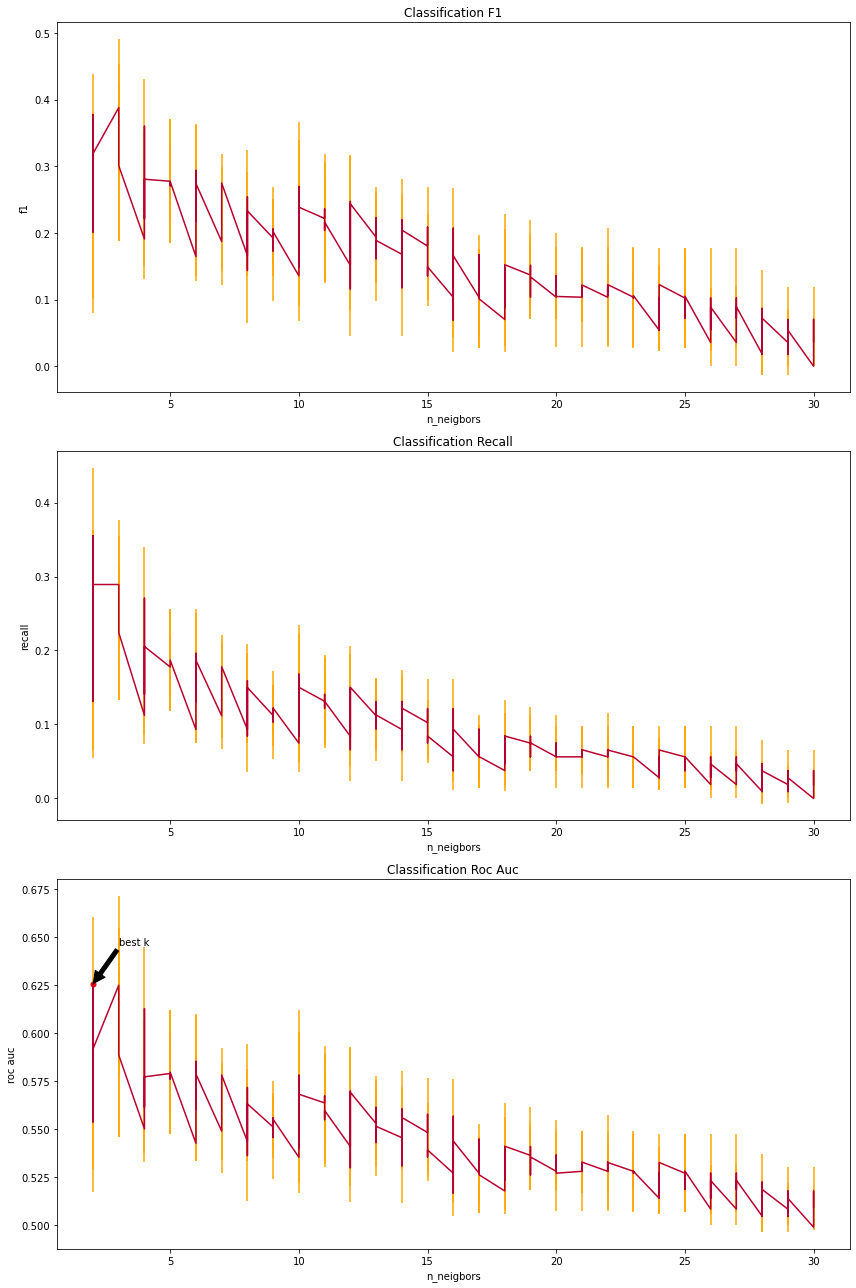



Permutation importances of the training set

OverTime                                           0.004536
DistanceFromHome                                   0.001515
JobSatisfaction                                    0.000061
RelationshipSatisfaction                           0.000057
JobRole_Laboratory_Technician                      0.000035
StockOptionLevel                                   0.000026
JobRole_Research_Scientist                         0.000026
Age                                                0.000016
JobRole_Sales_Representative                       0.000011
JobInvolvement                                     0.000010
EnvironmentSatisfaction                            0.000006
NumCompaniesWorked                                 0.000002
JobLevel                                           0.000000
JobRole_Manager_Research_&_Development             0.000000
JobRole_Manufacturing_Director                     0.000000
JobRole_Research_Director                          0.

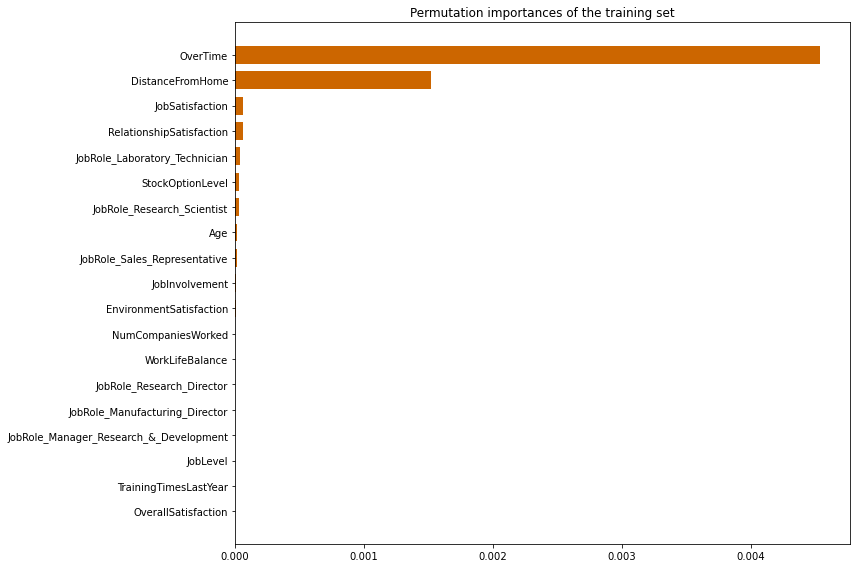



Predictions

Permutation importances of the test set

OverTime                                           0.103013
JobSatisfaction                                    0.058403
JobInvolvement                                     0.056820
WorkLifeBalance                                    0.055216
Age                                                0.043285
JobRole_Sales_Representative                       0.043245
RelationshipSatisfaction                           0.034500
EnvironmentSatisfaction                            0.029859
StockOptionLevel                                   0.028579
JobRole_Research_Scientist                         0.023799
JobLevel                                           0.022960
OverallSatisfaction                                0.019248
DistanceFromHome                                   0.015227
NumCompaniesWorked                                 0.007519
JobRole_Laboratory_Technician                      0.002348
JobRole_Research_Director                   

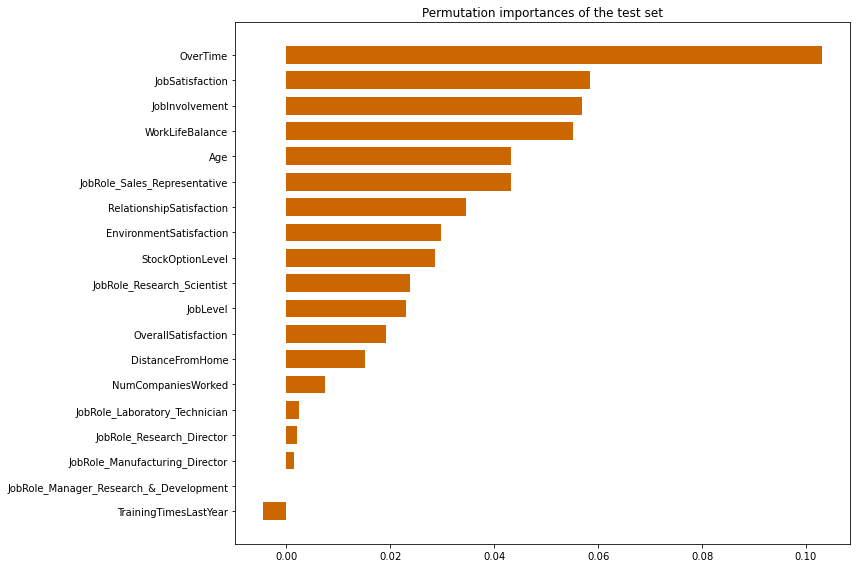



Confusion matrix


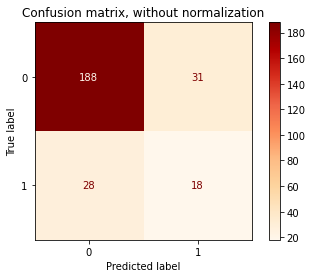

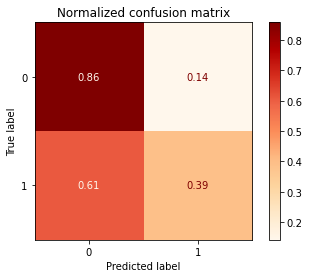


Classification report
              precision    recall  f1-score   support

           0       0.87      0.86      0.86       219
           1       0.37      0.39      0.38        46

    accuracy                           0.78       265
   macro avg       0.62      0.62      0.62       265
weighted avg       0.78      0.78      0.78       265


Metrics

Accuracy 0.7773584905660378
F1-score [0.86436782 0.37894737]
Precision [0.87037037 0.36734694]
Recall [0.85844749 0.39130435]
Roc_auc 0.6248759182052808


Roc curve



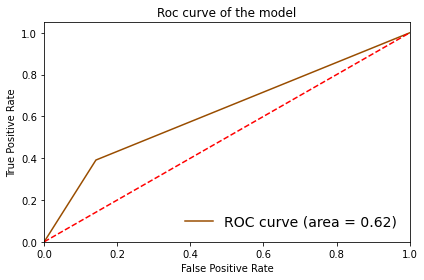


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.6931341140079541
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


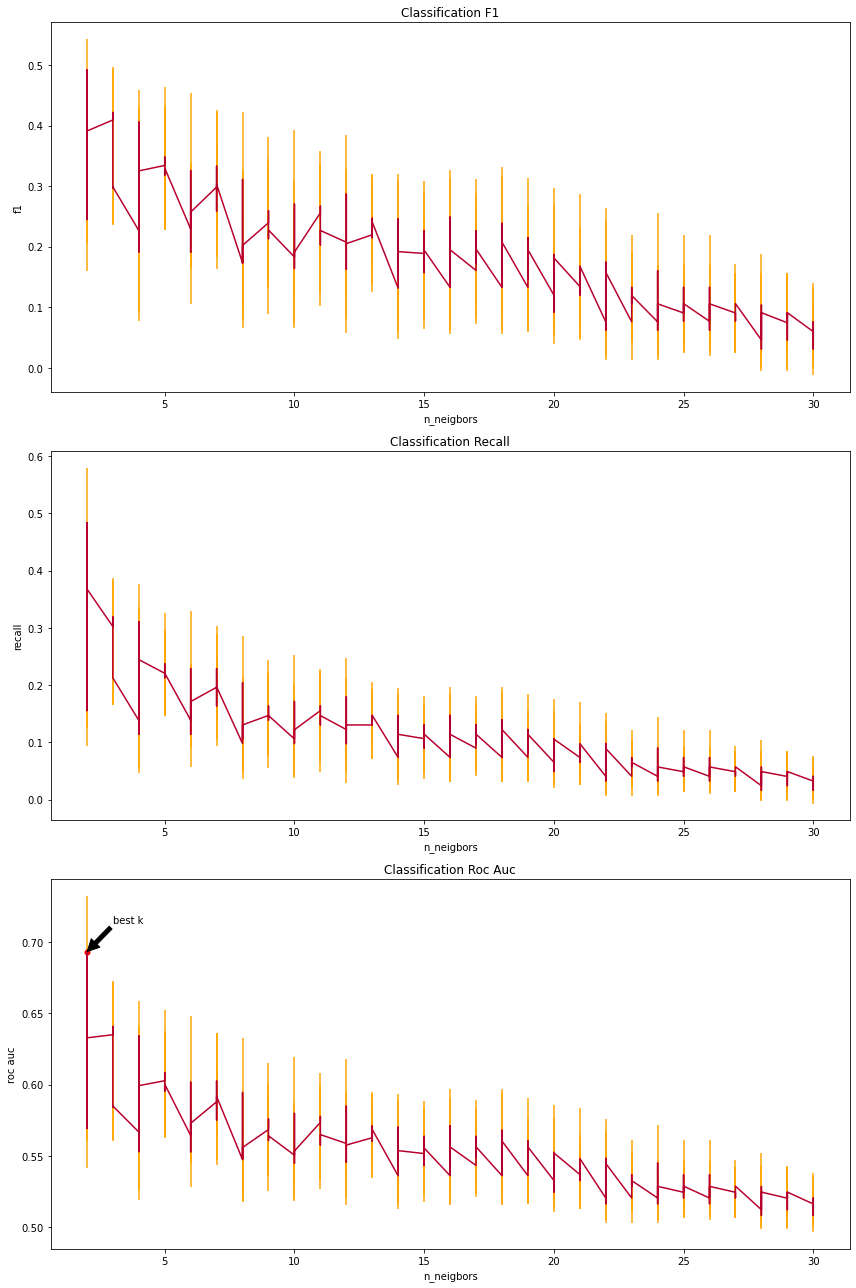



Permutation importances of the training set

OverTime                                           0.004564
JobRole_Sales_Representative                       0.004215
DistanceFromHome                                   0.001322
StockOptionLevel                                   0.000465
EnvironmentSatisfaction                            0.000229
JobSatisfaction                                    0.000079
JobRole_Laboratory_Technician                      0.000065
RelationshipSatisfaction                           0.000062
Age                                                0.000032
JobRole_Research_Scientist                         0.000018
NumCompaniesWorked                                 0.000011
TrainingTimesLastYear                              0.000011
JobInvolvement                                     0.000005
OverallSatisfaction                                0.000000
JobLevel                                           0.000000
JobRole_Manager_Research_&_Development             0.

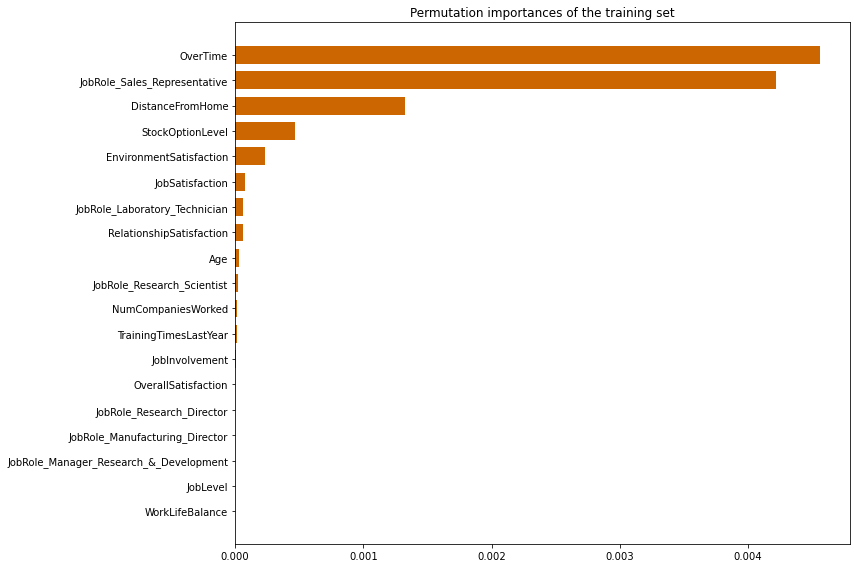



Predictions

Permutation importances of the test set

OverTime                                           0.106032
StockOptionLevel                                   0.063621
JobSatisfaction                                    0.049801
Age                                                0.043206
WorkLifeBalance                                    0.041814
JobInvolvement                                     0.037671
JobRole_Research_Scientist                         0.032103
JobRole_Laboratory_Technician                      0.031761
OverallSatisfaction                                0.027530
EnvironmentSatisfaction                            0.019741
JobRole_Sales_Representative                       0.018515
JobLevel                                           0.017720
TrainingTimesLastYear                              0.014837
DistanceFromHome                                   0.014229
RelationshipSatisfaction                           0.011213
NumCompaniesWorked                          

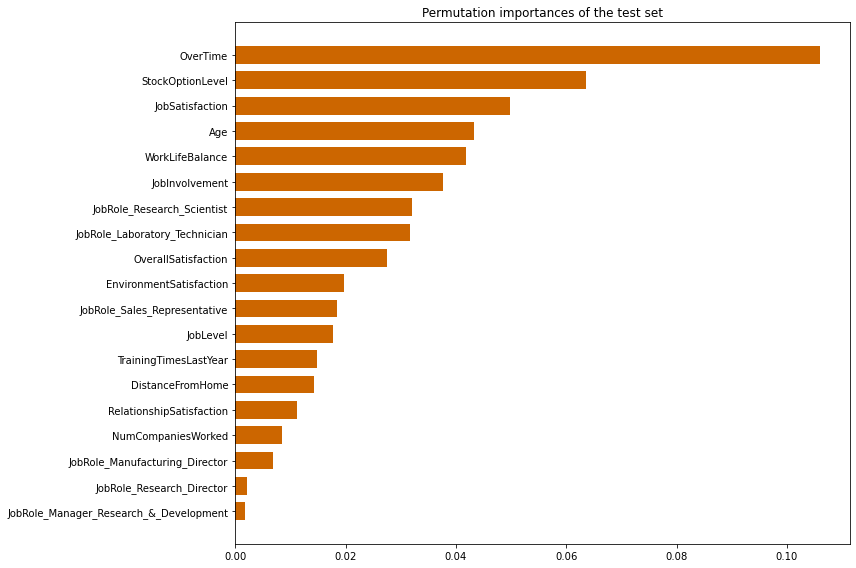



Confusion matrix


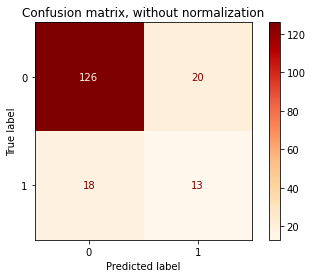

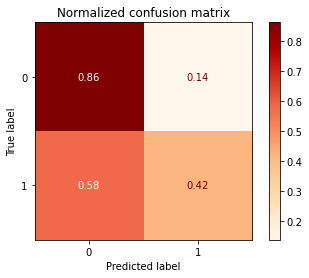


Classification report
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       146
           1       0.39      0.42      0.41        31

    accuracy                           0.79       177
   macro avg       0.63      0.64      0.64       177
weighted avg       0.79      0.79      0.79       177


Metrics

Accuracy 0.7853107344632768
F1-score [0.86896552 0.40625   ]
Precision [0.875      0.39393939]
Recall [0.8630137  0.41935484]
Roc_auc 0.6411842686699072


Roc curve



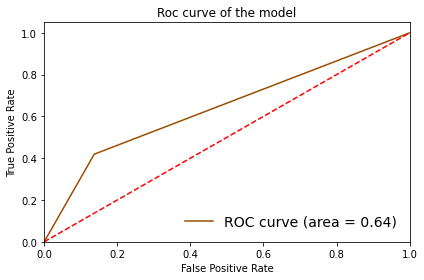


-------------------------------------------------------------------------------------------------------------



In [43]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = MinMaxScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    draw_roc_curve(y_test, y_pred)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()